# Preprocessing of spatio-temporally resolved single cell atlas of the Plasmodium liver stage

We pre-process the spatio-temporally resolved single cell atlas of the Plasmodium liver stage[[1]](https://www.nature.com/articles/s41586-022-05406-5). We use the `Seurat` object (`CS_data_seurat.rds`) and additional `metadata` files provided in [Zenodo](https://zenodo.org/record/7081863#.Y5jhCuxBxBw). 
The accompanying `.csv` files used in this notebook are provided under `data`.

[[1] Afriat, Amichay, Vanessa Zuzarte-Luís, Keren Bahar Halpern, Lisa Buchauer, Sofia Marques, Ângelo Ferreira Chora, Aparajita Lahree, Ido Amit, Maria M. Mota, and Shalev Itzkovitz. "A spatiotemporally resolved single-cell atlas of the Plasmodium liver stage." Nature 611, no. 7936 (2022): 563-569.](https://www.nature.com/articles/s41586-022-05406-5)


## load packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import re

import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns

from anndata import AnnData
import anndata2ri

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy as copy

In [3]:
sys.path.append("../../")
sys.path.append("../../utils/")
from paths import DATA_DIR, FIG_DIR

In [4]:
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

# Loading the rpy2 extension enables cell magic to be used
# This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

## set parameters

In [5]:
import mplscience

mplscience.set_style()
plt.rcParams["legend.scatterpoints"] = 1

In [6]:
DATA_DIR_LCL = str(DATA_DIR) + "/spatio-temporal-infection/"

In [7]:
abortive_genes = [
    "Myc",
    "Mdm2",
    "Cdkn1a",
    "Sqstm1",
    "Cxcl10",
    "Nfkbia",
    "Hes1",
    "Ifnb1",
]

In [8]:
stress_genes = [
    "Actg1",
    "Btg1",
    "Cxcl1",
    "Dnajb4",
    "Errfi1",
    "H3f3b",
    "Hspb1",
    "Irf1",
    "Klf6",
    "Mir22hg",
    "Nfkbia",
    "Pcf11",
    "Pxdc1",
    "Sdc4",
    "Srf",
    "Tpm3",
    "Usp2",
    "Gadd45g",
    "Ankrd1",
    "Btg2",
    "Cyr61",
    "Dusp1",
    "Fam132b",
    "Hipk3",
    "Hsph1",
    "Irf8",
    "Klf9",
    "Mt1",
    "Nfkbiz",
    "Pde4b",
    "Rap1b",
    "Serpine1",
    "Srsf5",
    "Tppp3",
    "Wac",
    "Hspe1",
    "Arid5a",
    "Ccnl1",
    "Dcn",
    "Dusp8",
    "Fos",
    "Hsp90aa1",
    "Id3",
    "Itpkc",
    "Litaf",
    "Mt2",
    "Nop58",
    "Per1",
    "Rassf1",
    "Skil",
    "Srsf7",
    "Tra2a",
    "Zc3h12a",
    "Ier5",
    "Atf3",
    "Ccrn4l",
    "Ddx3x",
    "Egr1",
    "Fosb",
    "Hsp90ab1",
    "Idi1",
    "Jun",
    "Lmna",
    "Myadm",
    "Nppc",
    "Phlda1",
    "Rhob",
    "Slc10a6",
    "Stat3",
    "Tra2b",
    "Zfand5",
    "Kcne4",
    "Atf4",
    "Cebpb",
    "Ddx5",
    "Egr2",
    "Fosl2",
    "Hspa1a",
    "Ier2",
    "Junb",
    "Maff",
    "Myc",
    "Nr4a1",
    "Pnp",
    "Rhoh",
    "Slc38a2",
    "Tagln2",
    "Trib1",
    "Zfp36",
    "Bag3",
    "Cebpd",
    "Des",
    "Eif1",
    "Gadd45a",
    "Hspa1b",
    "Ier3",
    "Jund",
    "Mafk",
    "Myd88",
    "Odc1",
    "Pnrc1",
    "Ripk1",
    "Slc41a1",
    "Tiparp",
    "Tubb4b",
    "Zfp36l1",
    "Bhlhe40",
    "Cebpg",
    "Dnaja1",
    "Eif5",
    "Gcc1",
    "Hspa5",
    "Ifrd1",
    "Klf2",
    "Mcl1",
    "Nckap5l",
    "Osgin1",
    "Ppp1cc",
    "Sat1",
    "Socs3",
    "Tnfaip3",
    "Tubb6",
    "Zfp36l2",
    "Brd2",
    "Csrnp1",
    "Dnajb1",
    "Erf",
    "Gem",
    "Hspa8",
    "Il6",
    "Klf4",
    "Midn",
    "Ncoa7",
    "Oxnad1",
    "Ppp1r15a",
    "Sbno2",
    "Sqstm1",
    "Tnfaip6",
    "Ubc",
    "Zyx",
]

In [9]:
infected_inc_genes = [
    "Ccl5",
    "Tmeff2",
    "Fth1",
    "Gstm1",
    "Gstm3",
    "Slpi",
    "Sprr1a",
    "Gsta1",
    "Gsta2",
    "Spp1",
    "Rsad2",
    "Ftl1",
    "Klf6",
    "Infb1",
    "Nfkbia",
    "Sqstm1",
    "Ccl2",
    "Cxcl10",
    "Ifit2",
    "Atf3",
    "Ccrl2",
    "Hmox1",
    "Ifnb1",
    "Srxn1",
    "Traf5",
    "Tlr2",
    "Fosl1",
    "Dusp8",
]

infected_dec_genes = [
    "Slco1a1",
    "Hao1",
    "Alb",
    "Apob",
    "G6pc",
    "Apoa1",
    "Fasn",
    "Acly",
    "Ahg",
    "Bhmt",
    "Fga",
    "Fgg",
    "Serpina1b",
    "Ldha",
]

ifn_genes = [
    "Ifnar1",
    "Irf9",
    "Ifna2",
    "Ifna4",
    "Ifnar1",
    "Ifnar2",
    "Ifnb1",
    "Ifngr1",
    "Ifngr2",
    "Ifnk",
    "Ifnlr1",
    "Ifnz",
    "Ifih1",
]

irf_genes = [
    "Irf1",
    "Irf2",
    "Irf2bp1",
    "Irf2bp2",
    "Irf2bpl",
    "Irf3",
    "Irf5",
    "Irf6",
    "Irf7",
    "Irf9",
]

## load (and preprocess) data

In [10]:
%%R -i DATA_DIR_LCL -o CS_adata
suppressPackageStartupMessages(library(Seurat))
print(paste(DATA_DIR_LCL, "CS_data_seurat.rds", sep=""))

CS_data = readRDS(paste(DATA_DIR_LCL, "CS_data_seurat.rds", sep=""))

#convert the Seurat object to a SingleCellExperiment object
CS_adata <- as.SingleCellExperiment(CS_data)

CS_adata

[1] "/cs/labs/mornitzan/zoe.piran/research/projects/biolord_reproducibility/data/spatio-temporal-infection/CS_data_seurat.rds"


/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


class: SingleCellExperiment 
dim: 19011 24968 
metadata(0):
assays(3): X logcounts scaledata
rownames(19011): 0610009B22Rik 0610010F05Rik ... Zzz3 ccdc198
rowData names(0):
colnames(24968): AACCTTG_IMM-feb20_M10_P29_24hpi
  AAGACTC_IMM-feb20_M10_P29_24hpi ...
  TTCAGTC_IMM-Jan22_M30_P48_MB-36hpi TTGGTCA_IMM-Jan22_M30_P48_MB-36hpi
colData names(29): barcode mouse ... cluster_names ident
reducedDimNames(2): PCA UMAP
altExpNames(0):


/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


In [11]:
CS_adata

AnnData object with n_obs × n_vars = 24968 × 19011
    obs: 'barcode', 'mouse', 'marker', 'time', 'infected', 'experiment', 'coarse_time', 'MB', 'eta', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mt_qc', 'SUMPBA', 'n_counts', 'n_genes', 'mus_rRNA', 'pba_rRNA', 'pba_rRNA_fraction', 'nCount_PBA', 'nFeature_PBA', 'nCount_MUS', 'nFeature_MUS', 'RNA_snn_res.0.2', 'seurat_clusters', 'MBinfected', 'cluster_names', 'ident'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts', 'scaledata'

### Create `counts` layer

In [12]:
CS_adata.layers["counts"] = CS_adata.X.copy()

### Update `var`

In [13]:
CS_adata.var["org"] = "mouse"
CS_adata.var.loc[CS_adata.var_names.str.startswith("PB"), "org"] = "pba"

### Update `obs`

In [14]:
# create `eta_normalized`
CS_adata.obs["eta_normalized"] = (CS_adata.obs["eta"] - CS_adata.obs["eta"].min()) / (
    CS_adata.obs["eta"].max() - CS_adata.obs["eta"].min()
)
# create `nCounts_tot`
CS_adata.obs["nCounts_tot"] = CS_adata.obs["nCount_MUS"] + CS_adata.obs["nCount_PBA"]
# create `normalized_PBA`
CS_adata.obs["normalized_PBA"] = (
    CS_adata.obs["nCount_PBA"] / CS_adata.obs["nCounts_tot"]
)

In [15]:
# Update `Mock` in `coarse_time`
CS_adata.obs["coarse_time_orig"] = CS_adata.obs["coarse_time"].copy()
CS_adata.obs["coarse_time"] = CS_adata.obs["coarse_time_orig"].astype(str)
CS_adata.obs.loc[CS_adata.obs["time"] == "mock", "coarse_time"] = "Mock"
CS_adata.obs["coarse_time"] = CS_adata.obs["coarse_time"].astype("category")

In [16]:
CS_adata.obs["coarse_time"] = CS_adata.obs["coarse_time"].cat.rename_categories(
    {
        "NI": "Control",
        "2hpi": "2 hpi",
        "12hpi": "12 hpi",
        "24hpi": "24 hpi",
        "30hpi": "30 hpi",
        "36hpi": "36 hpi",
    }
)

CS_adata.obs["coarse_time"] = CS_adata.obs["coarse_time"].cat.reorder_categories(
    [
        "Control",
        "Mock",
        "2 hpi",
        "12 hpi",
        "24 hpi",
        "30 hpi",
        "36 hpi",
    ]
)

In [17]:
# define `zone` using threshold from Afriat et al.

eta_thresh = np.quantile(CS_adata.obs["eta"], 0.3)
CS_adata.obs["zone"] = "Pericentral"
CS_adata.obs.loc[CS_adata.obs["eta"] > eta_thresh, "zone"] = "Periportal"

In [19]:
CS_adata.obs["status"] = "uninfected"
CS_adata.obs.loc[CS_adata.obs["infected"] == "TRUE", "status"] = "infected"

In [20]:
CS_adata.obs["status_control"] = CS_adata.obs["status"].astype(str).copy()
CS_adata.obs.loc[
    CS_adata.obs["status_control"] == "uninfected", "status_control"
] = "Uninfected"
CS_adata.obs.loc[
    CS_adata.obs["status_control"] == "infected", "status_control"
] = "Infected"
CS_adata.obs.loc[CS_adata.obs["coarse_time"] == "Control", "status_control"] = "Control"
CS_adata.obs["status_control"] = CS_adata.obs["status_control"].astype("category")

In [21]:
CS_adata.obs["time_int"] = CS_adata.obs["coarse_time"].copy()
CS_adata.obs["time_int"] = CS_adata.obs["time_int"].cat.rename_categories(
    lambda x: x.split(" ")[0]
)
CS_adata.obs["time_int"] = CS_adata.obs["time_int"].cat.rename_categories(
    {"Control": "0", "Mock": "0.1"}
)
CS_adata.obs["time_int"] = CS_adata.obs["time_int"].astype(float)

### Set `uns`

In [22]:
sns.color_palette(
    ["#BDC3C7", "#C7C1BD", "#826976", "#698269", "#B99B6B", "#F1DBBF", "#AA5656"]
)

[(0.7411764705882353, 0.7647058823529411, 0.7803921568627451),
 (0.7803921568627451, 0.7568627450980392, 0.7411764705882353),
 (0.5098039215686274, 0.4117647058823529, 0.4627450980392157),
 (0.4117647058823529, 0.5098039215686274, 0.4117647058823529),
 (0.7254901960784313, 0.6078431372549019, 0.4196078431372549),
 (0.9450980392156862, 0.8588235294117647, 0.7490196078431373),
 (0.6666666666666666, 0.33725490196078434, 0.33725490196078434)]

In [23]:
CS_adata.uns["coarse_time_colors"] = [
    "#BDC3C7",
    "#C7C1BD",
    "#826976",
    "#698269",
    "#B99B6B",
    "#F1DBBF",
    "#AA5656",
]

In [24]:
sns.color_palette(["#4A2055", "#F5DF28"])

[(0.2901960784313726, 0.12549019607843137, 0.3333333333333333),
 (0.9607843137254902, 0.8745098039215686, 0.1568627450980392)]

In [25]:
CS_adata.uns["zone_colors"] = ["#4A2055", "#F5DF28"]

In [26]:
sns.color_palette(["#C10000", "#DEDEDE"])

[(0.7568627450980392, 0.0, 0.0),
 (0.8705882352941177, 0.8705882352941177, 0.8705882352941177)]

In [27]:
CS_adata.uns["status_colors"] = ["#C10000", "#DEDEDE"]

In [28]:
sns.color_palette(["#bdc3c7", "#f01313", "#6f8e32"])

[(0.7411764705882353, 0.7647058823529411, 0.7803921568627451),
 (0.9411764705882353, 0.07450980392156863, 0.07450980392156863),
 (0.43529411764705883, 0.5568627450980392, 0.19607843137254902)]

In [29]:
CS_adata.uns["status_control_colors"] = ["#bdc3c7", "#f01313", "#6f8e32"]

### Keep only `injection` cells and mouse genes

In [30]:
CS_adata = CS_adata[CS_adata.obs["MB"] == "Injection", CS_adata.var["org"] == "mouse"]

## Create infected `adata`

Create an anndata object containing excluding `Mock` cells and restrict to genes reported by Afriat et al.

In [31]:
genes_ = pd.read_csv(DATA_DIR_LCL + "genes_subset_original.csv", index_col=0)

In [32]:
adata_infected = CS_adata[
    ~CS_adata.obs["coarse_time"].isin(["Mock"]), genes_.values.flatten()
].copy()

In [33]:
# standard pre-processing
sc.pp.normalize_total(adata_infected, target_sum=10000)
sc.pp.log1p(adata_infected)
sc.pp.highly_variable_genes(
    adata_infected, flavor="seurat_v3", layer="counts", n_top_genes=5000
)
sc.tl.pca(adata_infected, use_highly_variable=True)
sc.pp.neighbors(adata_infected)
sc.tl.umap(adata_infected)

/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


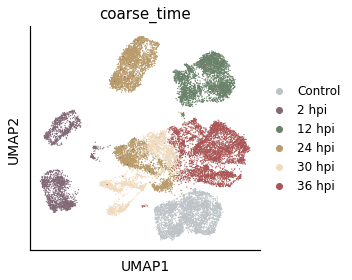

/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


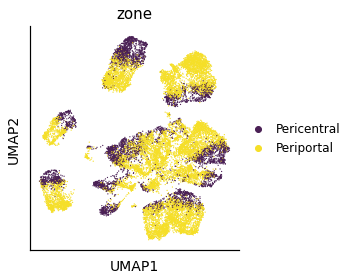

/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


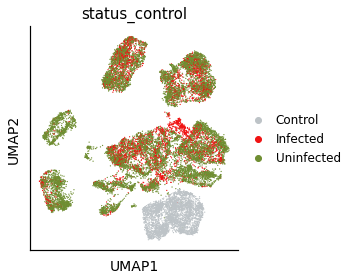

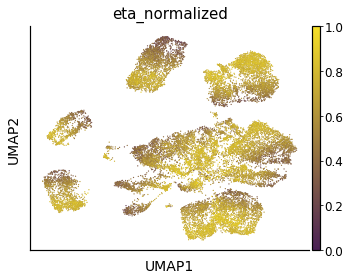

In [34]:
size = 4

for c in ["coarse_time", "zone", "status_control", "eta_normalized"]:
    fig, axs = plt.subplots(1, 1, figsize=(size + 1, size))

    sc.pl.umap(
        adata_infected,
        color=[c],
        ax=axs,
        show=False,
        cmap=sns.color_palette("blend:#4A2055,#F5DF28", as_cmap=True),
    )

    plt.tight_layout()
    plt.show()

### Create random split

In [35]:
adata_infected.obs["split_random"] = "nan"

# ood
adata_infected.obs.loc[
    adata_infected.obs["barcode"].isin(["GTACGGT"]), "split_random"
] = "ood"

adata_idx = adata_infected.obs_names[adata_infected.obs["split_random"] != "ood"]
adata_idx_train, adata_idx_test = train_test_split(
    adata_idx, test_size=0.1, random_state=42
)
adata_infected.obs.loc[adata_idx_train, "split_random"] = "train"
adata_infected.obs.loc[adata_idx_test, "split_random"] = "test"
adata_infected.obs["split_random"].value_counts()

train    17141
test      1905
ood          7
Name: split_random, dtype: int64

In [36]:
adata_infected.write(DATA_DIR_LCL + "adata_infected.h5ad")

## Create abortive `adata`

We focus on the infected late (24, 30 , and 36 hpi) population of cells.

In [37]:
pseudotime_ = pd.read_csv(DATA_DIR_LCL + "monocole_pseudotime.csv", index_col=0)
abortive_ = pd.read_csv(DATA_DIR_LCL + "abortive_status.csv", index_col=0)

In [38]:
adata_abortive = CS_adata[CS_adata.obs["infected"] == "TRUE", :].copy()

In [39]:
adata_abortive.obs["pseudotime"] = pseudotime_.loc[
    adata_abortive.obs_names, "pseudotime"
]

In [40]:
adata_abortive.obs["abortive"] = abortive_.loc[adata_abortive.obs_names, "abortive"]

In [41]:
adata_abortive.obs["abortive_state"] = adata_abortive.obs["abortive"].copy().astype(str)
adata_abortive.obs.loc[
    adata_abortive.obs["coarse_time"] != "36 hpi", "abortive_state"
] = "Unknown"
adata_abortive.obs["abortive_state"] = adata_abortive.obs["abortive_state"].astype(
    "category"
)

In [42]:
adata_abortive = adata_abortive[
    adata_abortive.obs["coarse_time"].isin(["24 hpi", "30 hpi", "36 hpi"]), :
]

In [43]:
sns.color_palette(["#ff7c7b", "#7bbcff", "#d3d3d3"])

[(1.0, 0.48627450980392156, 0.4823529411764706),
 (0.4823529411764706, 0.7372549019607844, 1.0),
 (0.8274509803921568, 0.8274509803921568, 0.8274509803921568)]

In [44]:
adata_abortive.uns["abortive_state_colors"] = ["#ff7c7b", "#7bbcff", "#d3d3d3"]

/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [45]:
# standard pre-processing
sc.pp.normalize_total(adata_abortive, target_sum=10000)
sc.pp.log1p(adata_abortive)
sc.pp.highly_variable_genes(
    adata_abortive, flavor="seurat_v3", layer="counts", n_top_genes=2000
)
sc.tl.pca(adata_abortive, use_highly_variable=True)
sc.pp.neighbors(adata_abortive)
sc.tl.umap(adata_abortive)

/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [46]:
sc.tl.score_genes(adata_abortive, stress_genes, score_name="stress_score")

/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [47]:
keep_ = adata_abortive.var_names.isin(
    [
        *infected_inc_genes,
        *infected_dec_genes,
        *ifn_genes,
        *irf_genes,
        *adata_abortive.var_names[adata_abortive.var["highly_variable"]].tolist(),
    ]
)

In [48]:
keep_[adata_abortive.var_names.isin(stress_genes)] = False
keep_[adata_abortive.var_names.isin(abortive_genes)] = True
keep_.sum()

1949

In [49]:
adata_abortive = adata_abortive[:, keep_]

/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of

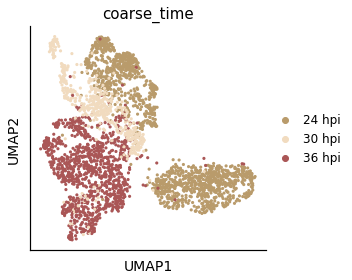

/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


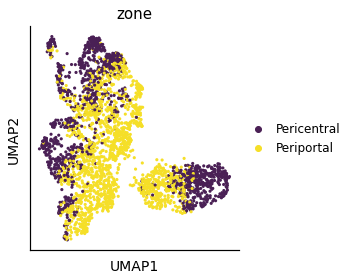

/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


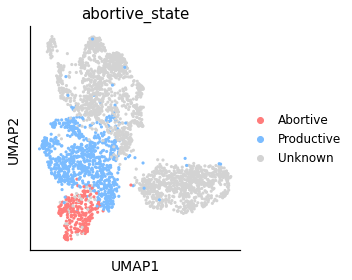

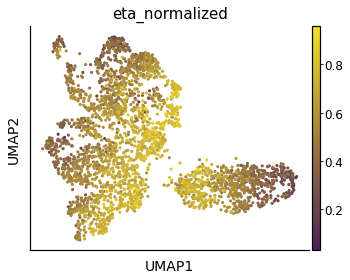

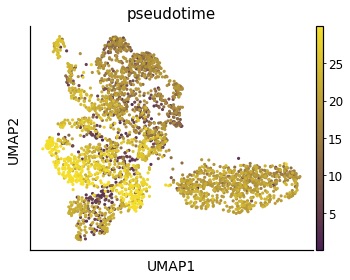

In [50]:
size = 4

for c in ["coarse_time", "zone", "abortive_state", "eta_normalized", "pseudotime"]:
    fig, axs = plt.subplots(1, 1, figsize=(size + 1, size))

    sc.pl.umap(
        adata_abortive,
        color=[c],
        ax=axs,
        show=False,
        cmap=sns.color_palette("blend:#4A2055,#F5DF28", as_cmap=True),
    )

    plt.tight_layout()
    plt.show()

In [51]:
adata_abortive.obs["split_random"] = "nan"

# ood
adata_abortive.obs.loc[
    adata_abortive.obs["barcode"].isin(["GTCATGC"]), "split_random"
] = "ood"

adata_idx = adata_abortive.obs_names[adata_abortive.obs["split_random"] != "ood"]
adata_idx_train, adata_idx_test = train_test_split(
    adata_idx, test_size=0.1, random_state=42
)
adata_abortive.obs.loc[adata_idx_train, "split_random"] = "train"
adata_abortive.obs.loc[adata_idx_test, "split_random"] = "test"
adata_abortive.obs["split_random"].value_counts()

train    2717
test      302
ood         5
Name: split_random, dtype: int64

In [52]:
adata_abortive.write(DATA_DIR_LCL + "adata_abortive.h5ad")